# spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [1]:
# 필요한 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data
- 보시면 spam.csv는 라벨이 있는 데이터예요. 물론 8주차 주체가 텍스트 기초인만큼 텍스트만 활용하셔도 되고 라벨까지 활용하셔서 모델을 돌려볼 수도 있어요!

우선 데이터를 읽어와서 전반적으로 한번 훑어보자. 본 데이터는 spam문자와 spam문자가 아닌 데이터의 텍스트들을 기록한 데이터이다.

In [2]:
spam = pd.read_csv('./spam.csv')
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

무작위로 하나를 지정해서 불러들여본 결과 메세지가 굉장히 noisy하다는 것을 파악할 수 있었다. nlp를 진행하면 대소문자 구분, 특수문자 제거, 숫자 제거 등을 신경써야겠다고 판단한다. 또한 결측치를 확인해보니 결측치는 없다고 나왔다.

In [4]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
spam.columns = ['label', 'text']
spam.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
spam['label'] = pd.get_dummies(spam['label'])
spam.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


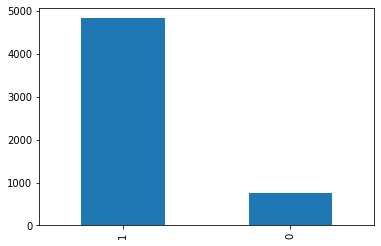

In [7]:
spam['label'].value_counts().plot(kind = 'bar')
plt.show()

혹여 앞으로 어떻게 분석할 지 모르기 때문에, 미리 spam과 ham을 dummy변수로 만들어줬다. 이 후, 간단하게 그래프를 그렸더니 spam 메세지의 비율이 현저하게 적었다.

## Tokenizing
- 실습코드는 물론 한국어 대상이라 konlpy를 다뤘지만, 슬라이드 보시면 영어는 nltk 모듈을 쓸 수 있어요. 의미 있는 토큰으로 쪼개고 불용어도 처리해보세요! 현존하는 불용어 리스트를 사용해도 좋고, 새롭게 만들어도 좋을 것 같아요!

In [8]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

tokenizing을 진행하기 앞서서 우선 전처리를 진행하자. 앞서 확인했던 것처럼 데이터는 정형화되지 않고 굉장히 불순물이 많이 섞여있다. 같은 단어인데 대소문자가 다르다거나 뜬금없이 !와 같은 특수문자가 임베딩 되는 상황을 막기 위함이다.  
  
    
for문을 통해 dataframe의 길이만큼 반복하며, 이메일 주소, url, 영어가 아닌 문자, 특수문자 순으로 제거해준다. 최종적으로 나온 결과값을 다시 data의 text열에 넣어준다.

In [9]:
preprocessing = []

for i in range(len(spam)):
    a = re.sub('([a-zA-Z0-9_.=-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)','',spam.text[i])
    b = re.sub('(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', a)
    c = re.sub('[^a-zA-Z]',' ', b)
    d = re.sub('[^\w\s]', '', c)
    preprocessing.append(d)
    
spam['text'] = preprocessing
spam.head()

,label,text
0,1,Go until jurong point crazy Available only ...
1,1,Ok lar Joking wif u oni
2,0,Free entry in a wkly comp to win FA Cup fina...
3,1,U dun say so early hor U c already then say
4,1,Nah I don t think he goes to usf he lives aro...


이 후, 대소문자의 구분을 없애기 위해 아래와 같이 전처리를 진행한다.

In [10]:
lower_text = []

for i in range(len(spam)):
    a = spam.text[i].lower()
    lower_text.append(a)

spam['text'] = lower_text
spam.head()

,label,text
0,1,go until jurong point crazy available only ...
1,1,ok lar joking wif u oni
2,0,free entry in a wkly comp to win fa cup fina...
3,1,u dun say so early hor u c already then say
4,1,nah i don t think he goes to usf he lives aro...


본격적인 tokenizing은 지금부터다. 해당 데이터는 영어기반이기 때문에 nltk를 사용한다.

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jj950\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

본격적인 tokenizing을 진행하고, 불용어 처리도 해야하기 때문에 위와 같이 불어와야 한다. 어떤 불용어가 있는지 간단하게 확인해봤다. I my me mine과 같이 자주 사용하나 큰 의미를 부여하기에는 부족한 단어들이 있음을 확인했다.

In [74]:
nltk.download('punkt')

stop_words = stopwords.words('english')

tokens = []
for i in spam['text']:
    tokenizing = nltk.word_tokenize(i)
    word = [w for w in tokenizing if w not in stop_words]
    tokens.append(word)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jj950\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


위와 같은 과정을 통해 tokenizing을 진행한다. 각 문장을 하나씩 불러들여서 tokenizing을 진행하고, 이 중 불용어가 아닌 것들만 모아서 값을 뽑아준다. 뽑아준 결과값은 아래와 같이 나왔다. 확실히 I나 you는 보이지 않음을 알 수 있다.

In [75]:
print(tokens)

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'u', 'oni'], ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply'], ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'], ['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though'], ['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent'], ['per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'callers', 'press', 'copy', 'friends', 'callertune'], ['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hours'], ['mobile', 'months', '

그러나 위의 corpus의 문제점은 tokenizing 과정 중 불필요해 보이는 단어들이 보인다는 점이다. c, n, p 등은 큰 의미를 부여하기에는 어려워보인다. u 같은 경우, you를 줄여쓴 것이지만, you 역시 불용어이므로 크게 신경쓰지 않기로 한다. 그러므로 길이가 2 미만인 단어들을 삭제하기로 했다. 과정은 아래와 같다.

In [76]:
for w in tokens:
    for i in w:
        if len(i) < 2:
            w.remove(i)
            
print(tokens)
            

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'oni'], ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'apply'], ['dun', 'say', 'early', 'hor', 'c', 'already', 'say'], ['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though'], ['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent'], ['per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'callers', 'press', 'copy', 'friends', 'callertune'], ['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hours'], ['mobile', 'months', 'r', 'entitled', 'update', 'lat

위에 나온 결과값이 최종적인 corpus라고 보면 된다.

## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었어요. 왜 이 임베딩 모델을 적용하게 되었는지 '비교' 결과와 함께 적어주세요!

임베딩은 총 cbow, skip-gram, fasttext 세 가지를 해보기로 했다. 우선 one-hot encoding은 연산이 너무 많고, 컴퓨팅 파워가 약해 불가능 할 것이라고 판단해 넘어가기로 했다. 그리고 glove 방식도 하고 싶었지만 무슨 이유에선지 설치되지 않아서 포기했다.

In [16]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [17]:
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [77]:
skip_gram = Word2Vec(tokens, size = 10, window = 5, min_count = 5, workers = 3, sg = 1)

In [78]:
cbow_model = Word2Vec(tokens, size = 10, window = 5, min_count = 5, workers = 3, sg = 0)

In [79]:
ft_model = FastText(tokens, size = 10, window = 5, min_count = 5, workers = 4, sg = 1)

각 모델의 코드는 위와 같다. 전반적인 옵션은 동일하게 줘서 성능을 비교해보기로 했다. size는 차원의 수를 의미하며 위의 코드들은 10차원의 벡터로 나타내란 의미다. window는 맥락의 개수를, min_count는 코퍼스 내의 최소 빈도이다. 최소 빈도보다 나오지 않는다면 학습을 진행하지 않는다. worker는 cpu 4개를 동시에 쓰란 의미이다. sg는 word2vec에서 0일 시 cbow를 1일 시 skip_gram을 구분지어준다.  
  
    
skip_gram이나 cbow의 경우, 학습 속도가 비슷비슷했다. 하지만 fasttext의 경우, 학습속도가 확연하게 차이날 정도로 느렸다.

In [80]:
vectors_sk = skip_gram.wv.vectors
vectors_sk

array([[ 0.58827347,  0.79103255,  0.13786267, ..., -0.7311057 ,
        -0.16968448,  0.92894083],
       [-0.25617686,  0.4541061 ,  0.38114423, ..., -0.2540636 ,
         0.01525088,  0.6890191 ],
       [ 0.009442  ,  0.5962379 ,  0.23481217, ..., -0.60135293,
         0.43677524,  0.63942933],
       ...,
       [-0.17102997,  0.3141135 ,  0.3557974 , ..., -0.18383802,
         0.08204022,  0.5254879 ],
       [-0.04128751,  0.4676796 ,  0.25412357, ..., -0.3023585 ,
         0.01472317,  0.56630623],
       [-0.13507082,  0.35145742,  0.35178947, ..., -0.15661994,
        -0.03159088,  0.4246545 ]], dtype=float32)

In [81]:
vectors_cb = cbow_model.wv.vectors
vectors_cb

array([[-0.723745  ,  1.4030429 ,  1.3888011 , ..., -0.15879902,
        -0.8829618 ,  2.4060388 ],
       [-0.6321166 ,  1.3090156 ,  1.364234  , ..., -0.10684405,
        -0.8504224 ,  2.192314  ],
       [-0.742755  ,  1.4403402 ,  1.5461028 , ..., -0.13258618,
        -0.88481283,  2.4512928 ],
       ...,
       [-0.10088666,  0.0955293 ,  0.19784266, ...,  0.02098931,
        -0.04475981,  0.25800487],
       [-0.01672168,  0.11743309,  0.05098056, ..., -0.01865816,
        -0.04860186,  0.15896195],
       [-0.02304966,  0.06854019,  0.10193782, ..., -0.01004729,
        -0.07057833,  0.09273501]], dtype=float32)

In [82]:
vectors_ft = ft_model.wv.vectors
vectors_ft

array([[-0.34756258,  0.13841218, -0.3662859 , ..., -1.2933043 ,
         1.2654221 , -0.6413708 ],
       [-0.0950008 , -0.04721354,  0.46413895, ..., -1.4433316 ,
         0.5466133 , -0.46367192],
       [-0.01727834,  0.13818435,  0.02996777, ..., -1.453969  ,
         0.5218404 , -0.05725966],
       ...,
       [-0.24783067, -0.03544842,  0.16227442, ..., -1.014315  ,
         0.7581759 , -0.36600095],
       [-0.17580152, -0.10446638,  0.22680517, ..., -1.2635976 ,
         0.8100237 , -0.39598012],
       [-0.19464897, -0.01608992,  0.1866499 , ..., -1.0114181 ,
         0.64449704, -0.36595395]], dtype=float32)

단어에 임베딩이 잘 진행됐는지 확인해봤다. 성능은 정확히는 모르지만, 각각 벡터로 잘 표현된 것 같다. 방식이 다르기 때문에, 각 벡터 값들도 서로 다른 것을 한 눈에 확인할 수 있다. 

## 본인이 도출해낸 해석을 적어주세요!

- Plot, Wordcloud, 이진 분류 모델, 유사도 뭐든 관계없으니 분명하고 인상적인 해석 부탁드려요!

우선 단어의 유사도를 확인해보기로 했다. 데이터를 한번 훑어봤을 때, spam message의 경우 free라는 단어가 있다는 점을 확인했다. 이를 바탕으로 각 모델별로 free를 넣었을 때, 어떤 단어들이 유사하다고 나올지 확인해보기로 했다. 단어의 개수는 20개만 뽑아본다.

In [83]:
skip_gram.most_similar('free',topn = 20)

C:\Users\jj950\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('tone', 0.9833784699440002),
 ('reply', 0.981252133846283),
 ('latest', 0.9804075360298157),
 ('nokia', 0.9802657961845398),
 ('mobile', 0.9745839834213257),
 ('camera', 0.9714561700820923),
 ('update', 0.9700031280517578),
 ('video', 0.9683501720428467),
 ('st', 0.9677869081497192),
 ('colour', 0.9661597013473511),
 ('text', 0.9653693437576294),
 ('orange', 0.9618915915489197),
 ('co', 0.9608724117279053),
 ('txt', 0.9603716135025024),
 ('sms', 0.9593615531921387),
 ('com', 0.9592558145523071),
 ('wk', 0.9591572284698486),
 ('tones', 0.9570454359054565),
 ('ringtone', 0.9568454623222351),
 ('stop', 0.9548699855804443)]

skip_gram에서 눈에 띄는 단어는 nokia, mobile, video, camera, com 등이 있다. 대부분의 spam 메세지는 우리나라와 다를 바 없이 공짜로 핸드폰이나 카메라를 바꿔준다 등인 가보다. com 같은 경우, 나름 전처리를 한다고 했으나 제대로 이루어지지 않은 듯하다. computer의 com이거나 .com의 com으로 추측된다.

In [84]:
cbow_model.most_similar('free',topn = 20)

C:\Users\jj950\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('call', 0.9997612237930298),
 ('gift', 0.9996981620788574),
 ('phone', 0.9995140433311462),
 ('collect', 0.9995022416114807),
 ('without', 0.9994009733200073),
 ('stop', 0.9993913173675537),
 ('go', 0.9993610978126526),
 ('code', 0.9993500709533691),
 ('please', 0.9993449449539185),
 ('st', 0.9993404746055603),
 ('week', 0.9993361830711365),
 ('prize', 0.9993258714675903),
 ('text', 0.9992972612380981),
 ('looking', 0.9992946982383728),
 ('miss', 0.9992773532867432),
 ('get', 0.9992383718490601),
 ('never', 0.9992309212684631),
 ('service', 0.9992117881774902),
 ('uk', 0.9991651773452759),
 ('pls', 0.9991508722305298)]

cbow에서 눈에 띄는 단어는 phone, call, week, miss, service, never 등이다. 추측컨데 핸드폰을 바꿔준다, 놓치지 마라, 이번 주다 등의 어구가 아닐까 싶다.

In [85]:
ft_model.most_similar('free',topn = 20)

C:\Users\jj950\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('nokia', 0.9937688112258911),
 ('phones', 0.9930585622787476),
 ('mob', 0.992365837097168),
 ('reply', 0.9902578592300415),
 ('mobiles', 0.9869397878646851),
 ('wk', 0.986791729927063),
 ('colour', 0.9865300059318542),
 ('weekly', 0.9856981039047241),
 ('tones', 0.9852541089057922),
 ('ringtones', 0.9852352142333984),
 ('mobileupd', 0.984677791595459),
 ('videophones', 0.9842376708984375),
 ('wkly', 0.9839419722557068),
 ('txts', 0.9835017919540405),
 ('video', 0.9831587672233582),
 ('ringtone', 0.982833981513977),
 ('poly', 0.9825342893600464),
 ('mobile', 0.982317328453064),
 ('com', 0.9809602499008179),
 ('club', 0.9799410700798035)]

fasttext는 nokia, mobiles, phones, videophones 등이 눈에 띈다. 역시 핸드폰과 관련된 spam 문자들이 많은 것 같다.  
  
    
개인적으로 느끼기에 가장 깔끔하고 빠르다는 느낌을 주는 것은 skip_gram이었다.

spam과 ham인 메세지를 구분해서 wordcloud를 만들어보기로 했다. 과정은 아래와 같다.

In [24]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


워드 클라우드를 만들 때, 다시 전처리를 진행했다. 그 이유는 우선 이전의 전처리에서는 크게 구분짓지 않았기 때문이며, wordcloud로 나타내려면 str 형식이 들어와야하는데 리스트 형식으로 만들었었기 때문이다.

In [58]:
stop_words = stopwords.words('english')

tokens2 = []
for i in spam[spam.label == 0].text:
    tokenizing = nltk.word_tokenize(i)
    for w in tokenizing:
        if w not in stop_words:
            tokens2.append(w)

tokens2 = ' '.join(tokens2)
print(tokens2)

free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv winner valued network customer selected receivea prize reward claim call claim code kl valid hours mobile months u r entitled update latest colour mobiles camera free call mobile update co free six chances win cash pounds txt csh send cost p day days tsandcs apply reply hl info urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw xxxmobilemovieclub use credit click wap link next txt message click xxxmobilemovieclub com n qjkgighjjgcbl england v macedonia dont miss goals team news txt ur national team eg england try wales scotland txt poboxox w wq thanks subscription ringtone uk mobile charged month please confirm replying yes reply charged rodger burns msg tried call reply sms free nokia mobile free camcorder please call delivery tomorrow sms ac sptv new jersey devils d

In [62]:
stop_words = stopwords.words('english')

tokens3 = []
for i in spam[spam.label == 1].text:
    tokenizing = nltk.word_tokenize(i)
    for w in tokenizing:
        if w not in stop_words:
            tokens3.append(w)

tokens3 = ' '.join(tokens3)
print(tokens3)

go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif u oni u dun say early hor u c already say nah think goes usf lives around though even brother like speak treat like aids patent per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune gon na home soon want talk stuff anymore tonight k cried enough today searching right words thank breather promise wont take help granted fulfil promise wonderful blessing times date sunday oh k watching eh u remember spell name yes v naughty make v wet fine way u feel way gota b seriously spell name going try months ha ha joking pay first lar da stock comin aft finish lunch go str lor ard smth lor u finish ur lunch already ffffffffff alright way meet sooner forced eat slice really hungry tho sucks mark getting worried knows sick turn pizza lol lol always convincing catch bus frying egg make tea eating mom left dinner feel love back amp packing car le

spam일 때와 ham일 때로 구분하여 전처리했고, 아래와 같이 wordcloud가 나왔다.

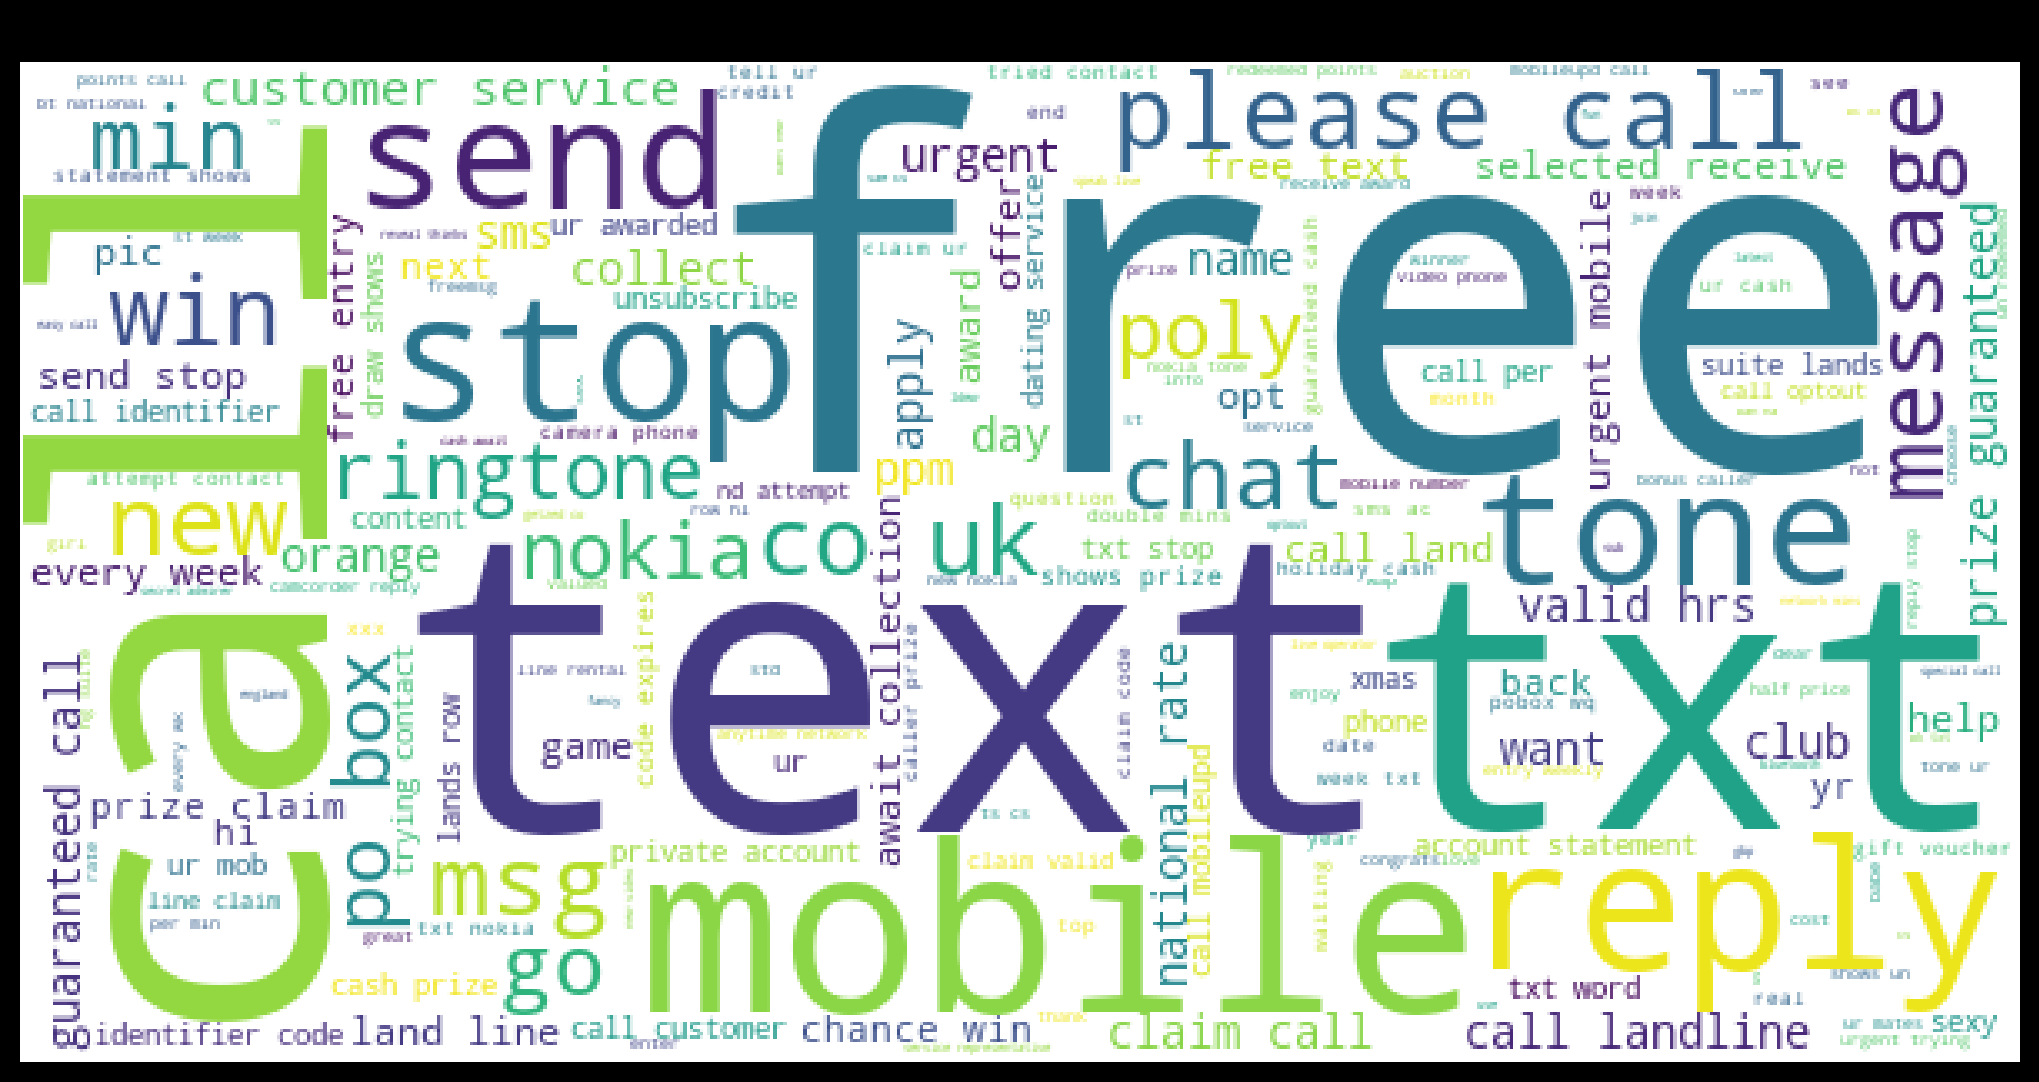

In [60]:
wc = WordCloud(background_color = 'white',width=600,height=300)

cld = wc.generate(tokens2)
plt.figure(figsize=(10,5), dpi=200, facecolor='k')
plt.imshow(cld)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WordCloud for Spam message')
plt.show()

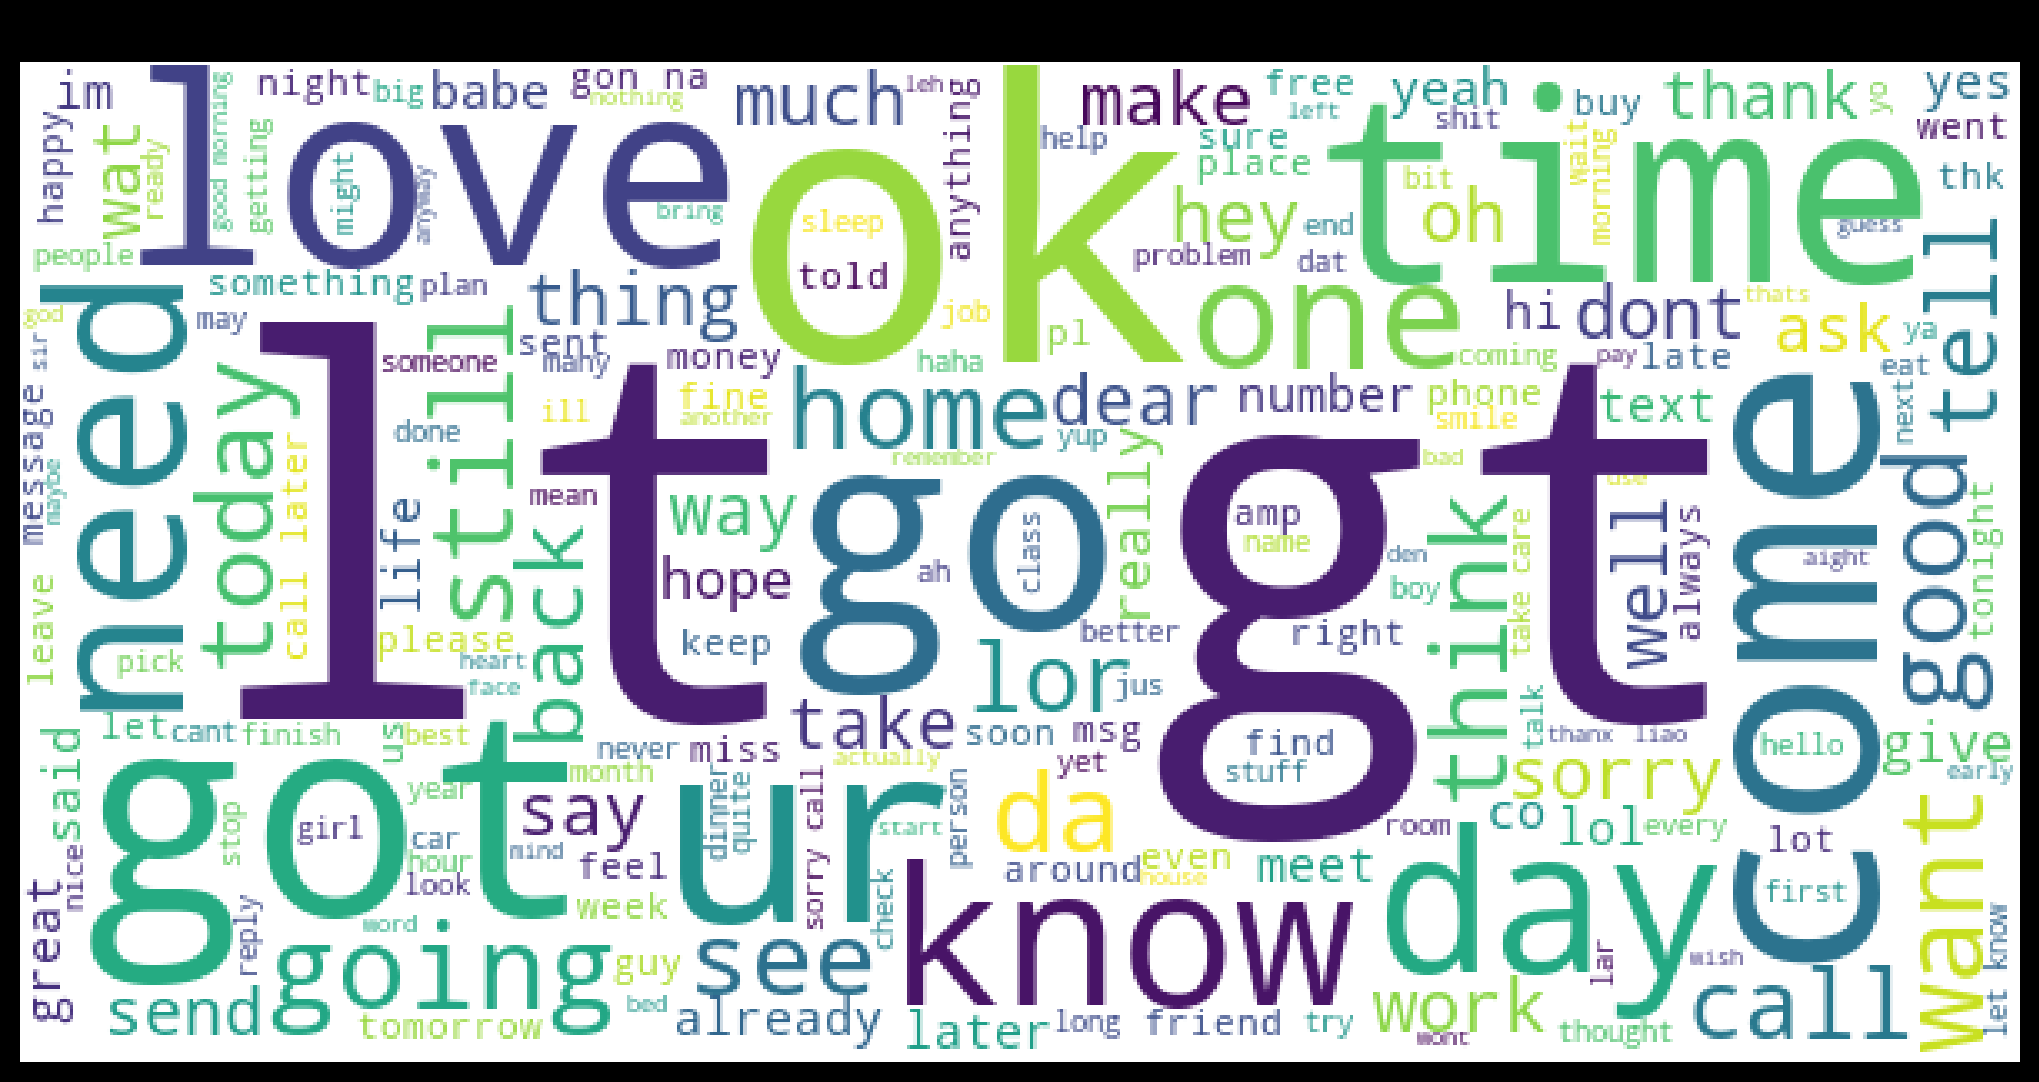

In [86]:
wc = WordCloud(background_color = 'white',width=600,height=300)

cld = wc.generate(tokens3)
plt.figure(figsize=(10,5), dpi=200, facecolor='k')
plt.imshow(cld)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WordCloud for ham message')
plt.show()

# Insight    

  
1. free를 바탕으로 단어 간의 유사도를 확인했을 때, 핸드폰과 관련된 단어들이 많았다. 이는 핸드폰을 무료로 바꿔주겠다 등의 내용인 스팸문자로 추측해볼 수 있다.(더 자세한 확인은 이진분류 모델을 진행해봐야 알 것 같다.)  
   
   
2. 또한 free의 경우, 세 모델에서 모두 week와 관련된 단어들이 도출됐다. 이는 기간을 걸어둔 것으로 '이번 주까지만 공짜!' 식의 문자가 아닐까라고 추측된다. 
     
     
3. 실제로 워드클라우드를 만들어서 확인해본 결과, spam 메세지일 경우, free가 가장 크게 나왔다. 게다가 앞선 임베딩 모델을 바탕으로 유사도를 확인했던 것처럼 핸드폰 관련 단어들이 많이 나왔다. 즉, 핸드폰을 바꿔줄테니 응답하라!의 내용인 것 같다.  
  
    
4. 반대로 ham의 경우, 감정적인 동사들이 많이 나왔다. 특히 우리나라의 줄임말 같은 단어들이 눈에 들어온다. ur 혹은 da 등은 친구 사이에서 사용하는 단어로 추측된다.  
  
    
5. 확실히 스팸문자의 경우, 상업적인 단어들이 많이 보이고, 일반 문자의 경우, 신변잡기적인 단어들이 많이 보인다. 